In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import hosts

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar
from astropy.utils import data

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)

# Viewing functions 

In [36]:
def show_in_decals(ra, dec=None, urltempl='http://legacysurvey.org/viewer?ra={}&dec={}', show=True):
    import webbrowser
        
    if dec is None:
        obj = ra
        if hasattr(obj, 'coords'):
            coo = obj.coords
        else:
            coo = SkyCoord.guess_from_table(obj, unit=u.deg)
            if coo.shape != tuple():
                raise ValueError('cant use table in show_in_decals')
    else:
        coo = SkyCoord(ra, dec, unit=u.deg)
    
    url = urltempl.format(coo.ra.deg, coo.dec.deg)
    if show:
        webbrowser.open(url)
    return url

# Load the brick data 

In [5]:
ls decals_dr3/

anakbricks                     survey-bricks.fits.gz
catalogs/                      survey-ccds-decals.fits.gz
dr3-depth.fits.gz              survey-ccds-extra.fits.gz
in_sdss.npy                    survey-ccds-nondecals.fits.gz
survey-bricks-dr3.fits.gz


In [6]:
ls decals_dr4/

in_sdss.npy                survey-bricks.fits.gz
survey-bricks-dr4.fits.gz


In [7]:
bricks = Table.read('decals_dr4/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')
bricksdr4 = Table.read('decals_dr4/survey-bricks-dr4.fits.gz')

# SAGA hosts

In [8]:
paper1nsas_comp = [166313,147100,165536,61945,132339,149781,33446,150887]
paper1nsas_incomp = [161174,85746,145729,140594,126115,13927,137625,129237]
paper1nsas = paper1nsas_comp + paper1nsas_incomp

In [9]:
hostobjs = hosts.get_saga_hosts_from_google()
paperhosts = [h for h in hostobjs if h.nsaid in paper1nsas]
assert len(paperhosts) == len(paper1nsas)

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [92]:
paperhostscs = SkyCoord([h.coords for h in paperhosts])

In [81]:
def find_host_bricks(hostlst, bricksdr, environfactor=1.2, brick_check_func=np.any):
    subbricks = bricks['BRICKNAME', 'RA1', 'RA2', 'DEC1', 'DEC2']
    subbricks.rename_column('BRICKNAME', 'brickname')
    joined = table.join(subbricks, bricksdr)
    
    schosts = SkyCoord([h.coords for h in hostlst])
    hostnames = np.array([h.name for h in hostlst])
    if hasattr(environfactor, 'unit'):
        environrad = [environfactor.value for h in hostlst]*environfactor.unit
    else:
        environrad = [environfactor*h.environsarcmin for h in hostlst]*u.arcmin

    # we do the ravel because match_to_catalog_sky works best with 1d
    brickras = np.array([joined['RA1'], joined['RA1'], joined['RA2'], joined['RA2']]).ravel()
    brickdecs = np.array([joined['DEC1'], joined['DEC2'], joined['DEC1'], joined['DEC2']]).ravel()
    brickedge_scs = SkyCoord(brickras, brickdecs, unit=u.deg)
    
    idx, d2d, _ = brickedge_scs.match_to_catalog_sky(schosts)
    # reshape so that each *brick* is represented
    bricksidx = idx.reshape(4, idx.size//4)
    bricksd2d = d2d.reshape(4, idx.size//4)
    
    bricksin = brick_check_func(bricksd2d < environrad[bricksidx], axis=0)
    
    res = joined[bricksin]
    
    # do this matching b/c it's *possible* multiple matches exist if a brick is near-equidistant
    closest_host_idx = SkyCoord.guess_from_table(res, unit=u.deg).match_to_catalog_sky(schosts)[0]
    res['closest_host_idx'] = closest_host_idx
    res['closest_host_name'] = hostnames[closest_host_idx]
    
    return res

446


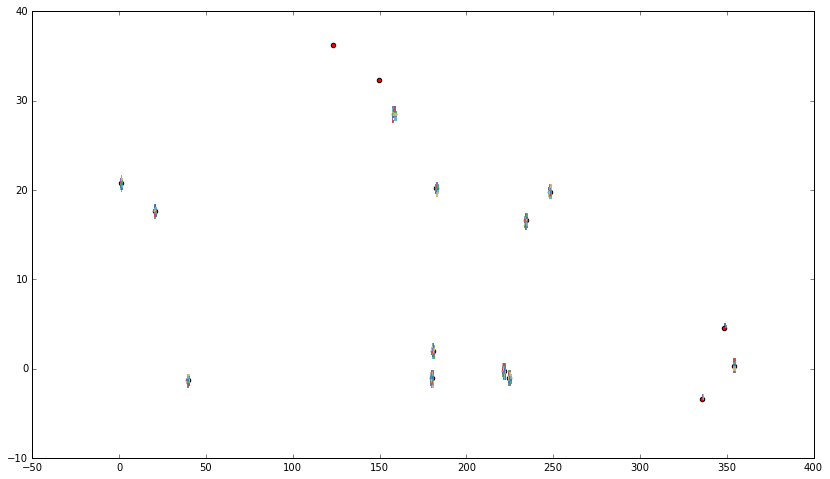

In [94]:
host_bricks_3 = find_host_bricks(paperhosts, bricksdr3)

for brick in host_bricks_3:
    x = [brick['RA1'], brick['RA2'], brick['RA2'], brick['RA1'], brick['RA1']]
    y = [brick['DEC1'], brick['DEC1'], brick['DEC2'], brick['DEC2'], brick['DEC1']]
    plt.plot(x, y)
    
plt.scatter(paperhostscs.ra.deg, paperhostscs.dec.deg, c='r')

len(host_bricks_3)

71

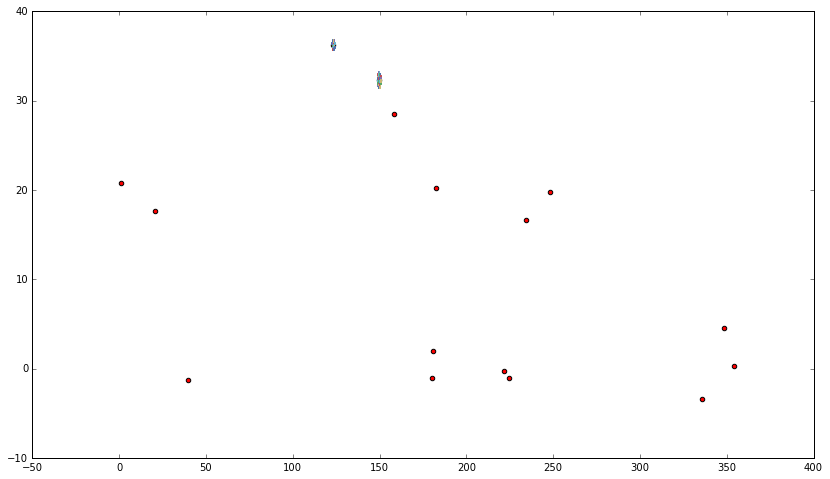

In [95]:
host_bricks_4 = find_host_bricks(paperhosts, bricksdr4)

for brick in host_bricks_4:
    x = [brick['RA1'], brick['RA2'], brick['RA2'], brick['RA1'], brick['RA1']]
    y = [brick['DEC1'], brick['DEC1'], brick['DEC2'], brick['DEC2'], brick['DEC1']]
    plt.plot(x, y)
    
plt.scatter(paperhostscs.ra.deg, paperhostscs.dec.deg, c='r')

len(host_bricks_4)

In [98]:
host_bricks_3

brickname,RA1,RA2,DEC1,DEC2,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,ebv,trans_g,trans_r,trans_z,closest_host_idx,closest_host_name
str8,float64,float64,float64,float64,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,int64,str11
0003p202,0.2658788774,0.531757754801,20.125,20.375,0.3988183161,20.25,0,0,5,0 .. 0,0 .. 0,120817 .. 8188992,1984,1042,578,234,120,10,0.0,0.0,1.37468,0.0515558,0.85846,0.902304,0.944118,7,Bandamanna
0004p205,0.266666666667,0.533333333333,20.375,20.625,0.4,20.5,0,0,5,0 .. 0,0 .. 0,165218 .. 8096400,1647,847,520,190,80,10,0.0,0.0,1.38472,0.0598364,0.837673,0.887527,0.935439,7,Bandamanna
0004p207,0.26706231454,0.53412462908,20.625,20.875,0.40059347181,20.75,0,0,4,0 .. 0,0 .. 0,252263 .. 4797094,1661,883,483,192,93,10,0.0,0.0,1.39148,0.059243,0.839145,0.888578,0.936058,7,Bandamanna
0004p210,0.267459138187,0.534918276374,20.875,21.125,0.401188707281,21.0,0,0,1,0 .. 0,0 .. 0,1354173 .. 0,1620,814,514,181,99,12,0.0,0.0,1.1991,0.0554702,0.84857,0.895288,0.940005,7,Bandamanna
0004p212,0.267857142857,0.535714285714,21.125,21.375,0.401785714286,21.25,0,0,1,0 .. 0,0 .. 0,1271401 .. 0,1656,837,515,181,110,13,0.0,0.0,1.19413,0.0441307,0.877537,0.915762,0.95197,7,Bandamanna
0006p202,0.531757754801,0.797636632201,20.125,20.375,0.664697193501,20.25,0,0,6,0 .. 0,0 .. 0,439 .. 9446212,2191,1185,636,254,105,11,0.0,0.0,1.3533,0.0388328,0.891408,0.925488,0.957612,7,Bandamanna
0006p205,0.533333333333,0.8,20.375,20.625,0.666666666667,20.5,0,0,5,0 .. 0,0 .. 0,131929 .. 8421544,1649,864,509,194,74,8,0.0,0.0,1.38377,0.0535341,0.853447,0.898751,0.942037,7,Bandamanna
0006p207,0.53412462908,0.80118694362,20.625,20.875,0.66765578635,20.75,0,0,3,0 .. 0,0 .. 0,39476 .. 3611242,1866,999,540,198,124,5,0.0,0.0,1.30452,0.0529583,0.854903,0.899784,0.942642,7,Bandamanna
0006p210,0.534918276374,0.802377414562,20.875,21.125,0.668647845468,21.0,0,0,1,0 .. 0,0 .. 0,1185255 .. 0,1578,819,463,175,113,8,0.0,0.0,1.21821,0.0591779,0.839307,0.888693,0.936126,7,Bandamanna


In [99]:
host_bricks_4

brickname,RA1,RA2,DEC1,DEC2,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,ebv,trans_g,trans_r,trans_z,ext_g,ext_r,ext_z,wise_nobs [4],trans_wise [4],ext_w1,ext_w2,ext_w3,ext_w4,closest_host_idx,closest_host_name
str8,float64,float64,float64,float64,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,int64,str11
1224p365,122.275862069,122.586206897,36.375,36.625,122.431034483,36.5,2,3,3,42560 .. 0,45472 .. 283558,23305 .. 0,2900,1556,929,285,123,7,1.86026,1.75698,1.55165,23.9837,23.595,23.0664,23.6696,23.1943,22.8189,0.0702986,0.812127,0.869203,0.924586,0.22594,0.152196,0.0851316,63 .. 14,0.988157 .. 0.999411,0.012935,0.00794375,0.0016942,0.000639701,9,StarTrek
1225p360,122.363013699,122.671232877,35.875,36.125,122.517123288,36.0,2,3,2,31869 .. 0,30404 .. 0,72872 .. 0,3206,1583,1107,378,125,13,1.7805,1.68196,1.55851,24.0147,23.6513,22.9206,23.6397,23.2453,22.6794,0.0546906,0.85053,0.896681,0.940823,0.175776,0.118405,0.0662304,61 .. 12,0.990774 .. 0.999542,0.0100631,0.00618003,0.00131801,0.000497707,9,StarTrek
1226p362,122.474226804,122.783505155,36.125,36.375,122.628865979,36.25,2,3,3,129334 .. 0,31498 .. 14093,21479 .. 49656,3030,1556,1005,347,114,8,1.76505,1.78277,1.567,23.9437,23.5719,23.1271,23.6305,23.1278,22.9187,0.0555938,0.848259,0.895067,0.939876,0.178679,0.120361,0.0673241,64 .. 14,0.990623 .. 0.999534,0.0102292,0.00628209,0.00133978,0.00050593,9,StarTrek
1227p357,122.559726962,122.866894198,35.625,35.875,122.71331058,35.75,2,3,2,50999 .. 0,34653 .. 1878601,21625 .. 0,3312,1663,1171,352,115,11,1.81249,1.66327,1.59469,23.9595,23.6553,22.9347,23.6307,23.2481,22.6935,0.0515692,0.858425,0.902279,0.944104,0.165743,0.111647,0.0624503,61 .. 12,0.991299 .. 0.999568,0.00948869,0.00582733,0.00124285,0.000469285,9,StarTrek
1227p365,122.586206897,122.896551724,36.375,36.625,122.74137931,36.5,2,3,3,26935 .. 0,33751 .. 259216,29058 .. 1138042,3493,1731,1130,457,163,12,1.83566,1.7585,1.4388,23.9219,23.485,23.2551,23.6154,23.1345,22.9846,0.0705067,0.811627,0.868843,0.924371,0.226609,0.152647,0.0853837,62 .. 12,0.988122 .. 0.999409,0.0129733,0.00796729,0.00169919,0.000641579,9,StarTrek
1228p360,122.671232877,122.979452055,35.875,36.125,122.825342466,36.0,2,3,3,53518 .. 0,38155 .. 0,19895 .. 228851,3396,1671,1060,469,182,14,1.79508,1.70336,1.67675,23.9946,23.6433,23.0832,23.6387,23.2451,22.879,0.0509428,0.860019,0.903407,0.944764,0.16373,0.110291,0.0616917,63 .. 13,0.991404 .. 0.999573,0.00937347,0.00575655,0.00122769,0.000463587,9,StarTrek
1228p367,122.698961938,123.010380623,36.625,36.875,122.85467128,36.75,2,3,3,55781 .. 0,57465 .. 13937,33026 .. 47841,3426,1594,1119,493,207,13,1.86479,1.58467,1.29879,23.8714,23.7082,23.2853,23.5548,23.2112,22.9651,0.0551433,0.849391,0.895872,0.940348,0.17723,0.119385,0.0667785,63 .. 13,0.990698 .. 0.999538,0.0101464,0.00623119,0.00132896,0.000501786,9,StarTrek
1229p362,122.783505155,123.092783505,36.125,36.375,122.93814433,36.25,2,3,3,95213 .. 0,20543 .. 53185,13167 .. 99227,3464,1734,1176,385,163,6,1.78123,1.7001,1.56154,23.9934,23.6635,23.1584,23.6872,23.2539,22.9293,0.0662298,0.821968,0.876284,0.928792,0.212863,0.143388,0.0802042,64 .. 14,0.988839 .. 0.999445,0.0121863,0.007484,0.00159614,0.000602663,9,StarTrek
1230p357,122.866894198,123.174061433,35.625,35.875,123.020477816,35.75,2,4,3,18058 .. 0,12020 .. 1564477,6935 .. 137940,3524,1839,1149,384,145,7,1.64836,1.50507,1.68928,24.0128,23.7053,23.0867,23.5556,23.253,22.8764,0.0521589,0.856928,0.901219,0.943483,0.167639,0.112924,0.0631644,62 .. 12,0.9912 .. 0.999563,0.00959719,0.00589396,0.00125704,0.000474658,9,StarTrek


In [106]:


_NERSC_BASE = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/'
def brickname_to_catalog_url(brickname, drnum, baseurl=_NERSC_BASE):
    catalogurl = baseurl + '/dr' + str(drnum) + '/tractor'

    dirnm = brickname[:3]

    return catalogurl + '/' + dirnm + '/tractor-' + brickname + '.fits'

brickname_to_catalog_url(bricksdr3[0]['brickname'], 3)

'http://portal.nersc.gov/project/cosmo/data/legacysurvey//dr3/tractor/000/tractor-0001m002.fits'

# OLD 

In [ ]:
1/0  # prevents the below from running

In [ ]:
SDSS_SQL_URL = 'http://skyserver.sdss.org/dr13/SkyServerWS/SearchTools/SqlSearch'

def in_sdss(sc):
    res = requests.get(SDSS_SQL_URL, dict(cmd="select dbo.fInFootprintEq({0.ra.deg},{0.dec.deg},0.1)".format(sc), 
                                          format='csv'))
    return 'True' in res.text.split('\n')